### Przygotowanie środowiska programistycznego

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, roc_auc_score, make_scorer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
import sklearn.metrics as metrics
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets
from termcolor import colored
from sklearn.feature_extraction.text import CountVectorizer

### Wczytanie danych

Poniższa komórka wczytuje dane.

Dane zawierają informacje o chemicznych właściwościach win oraz o przynależności do jednej z klas ('label'), odpowiadającym rodzajom wina. W dalszej części spróbujemy sklasyfikować dane wino na podstawie jego właściwości chemicznych.

Ze względu na dużą ilość cech, wybrano tylko część z nich aby przyspieszyć obliczenia.

In [3]:
wine = datasets.load_wine()
df1 = pd.DataFrame(wine.data, columns=wine.feature_names)[['alcohol', 'ash', 'alcalinity_of_ash',
       'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue']]
df1["label"] = wine.target
df1.head()

,alcohol,ash,alcalinity_of_ash,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,label
0,14.23,2.43,15.6,3.06,0.28,2.29,5.64,1.04,0
1,13.20,2.14,11.2,2.76,0.26,1.28,4.38,1.05,0
2,13.16,2.67,18.6,3.24,0.30,2.81,5.68,1.03,0
3,14.37,2.50,16.8,3.49,0.24,2.18,7.80,0.86,0
4,13.24,2.87,21.0,2.69,0.39,1.82,4.32,1.04,0


In [130]:
df1.columns

Index(['alcohol', 'ash', 'alcalinity_of_ash', 'flavanoids',
       'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue',
       'label'],
      dtype='object')

# Zadanie 1 (5 pkt)
### Analiza wizualna danych

**Proszę:**

* (3 pkt) Przeprowadzić analizę wizualną danych korzystając z dowolnych wizualizacji, które były użyte na ćwiczeniach
* (2 pkt) Na podstawie analizy wybierz dwie cechy które, według Ciebie, są optymalne do klasyfikacji rodzaju wina. Uzasadnij swój wybór.

Sprawdzenie czy klasy są w miarę zbilansowane:

<AxesSubplot:>

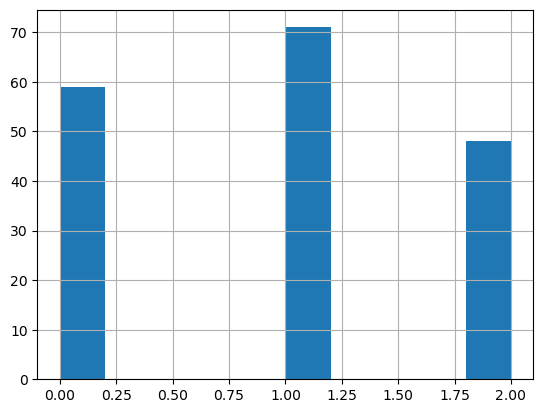

In [131]:
df1['label'].hist()

Najpierw popatrzmy na zależności między wszyskimi kolumnami

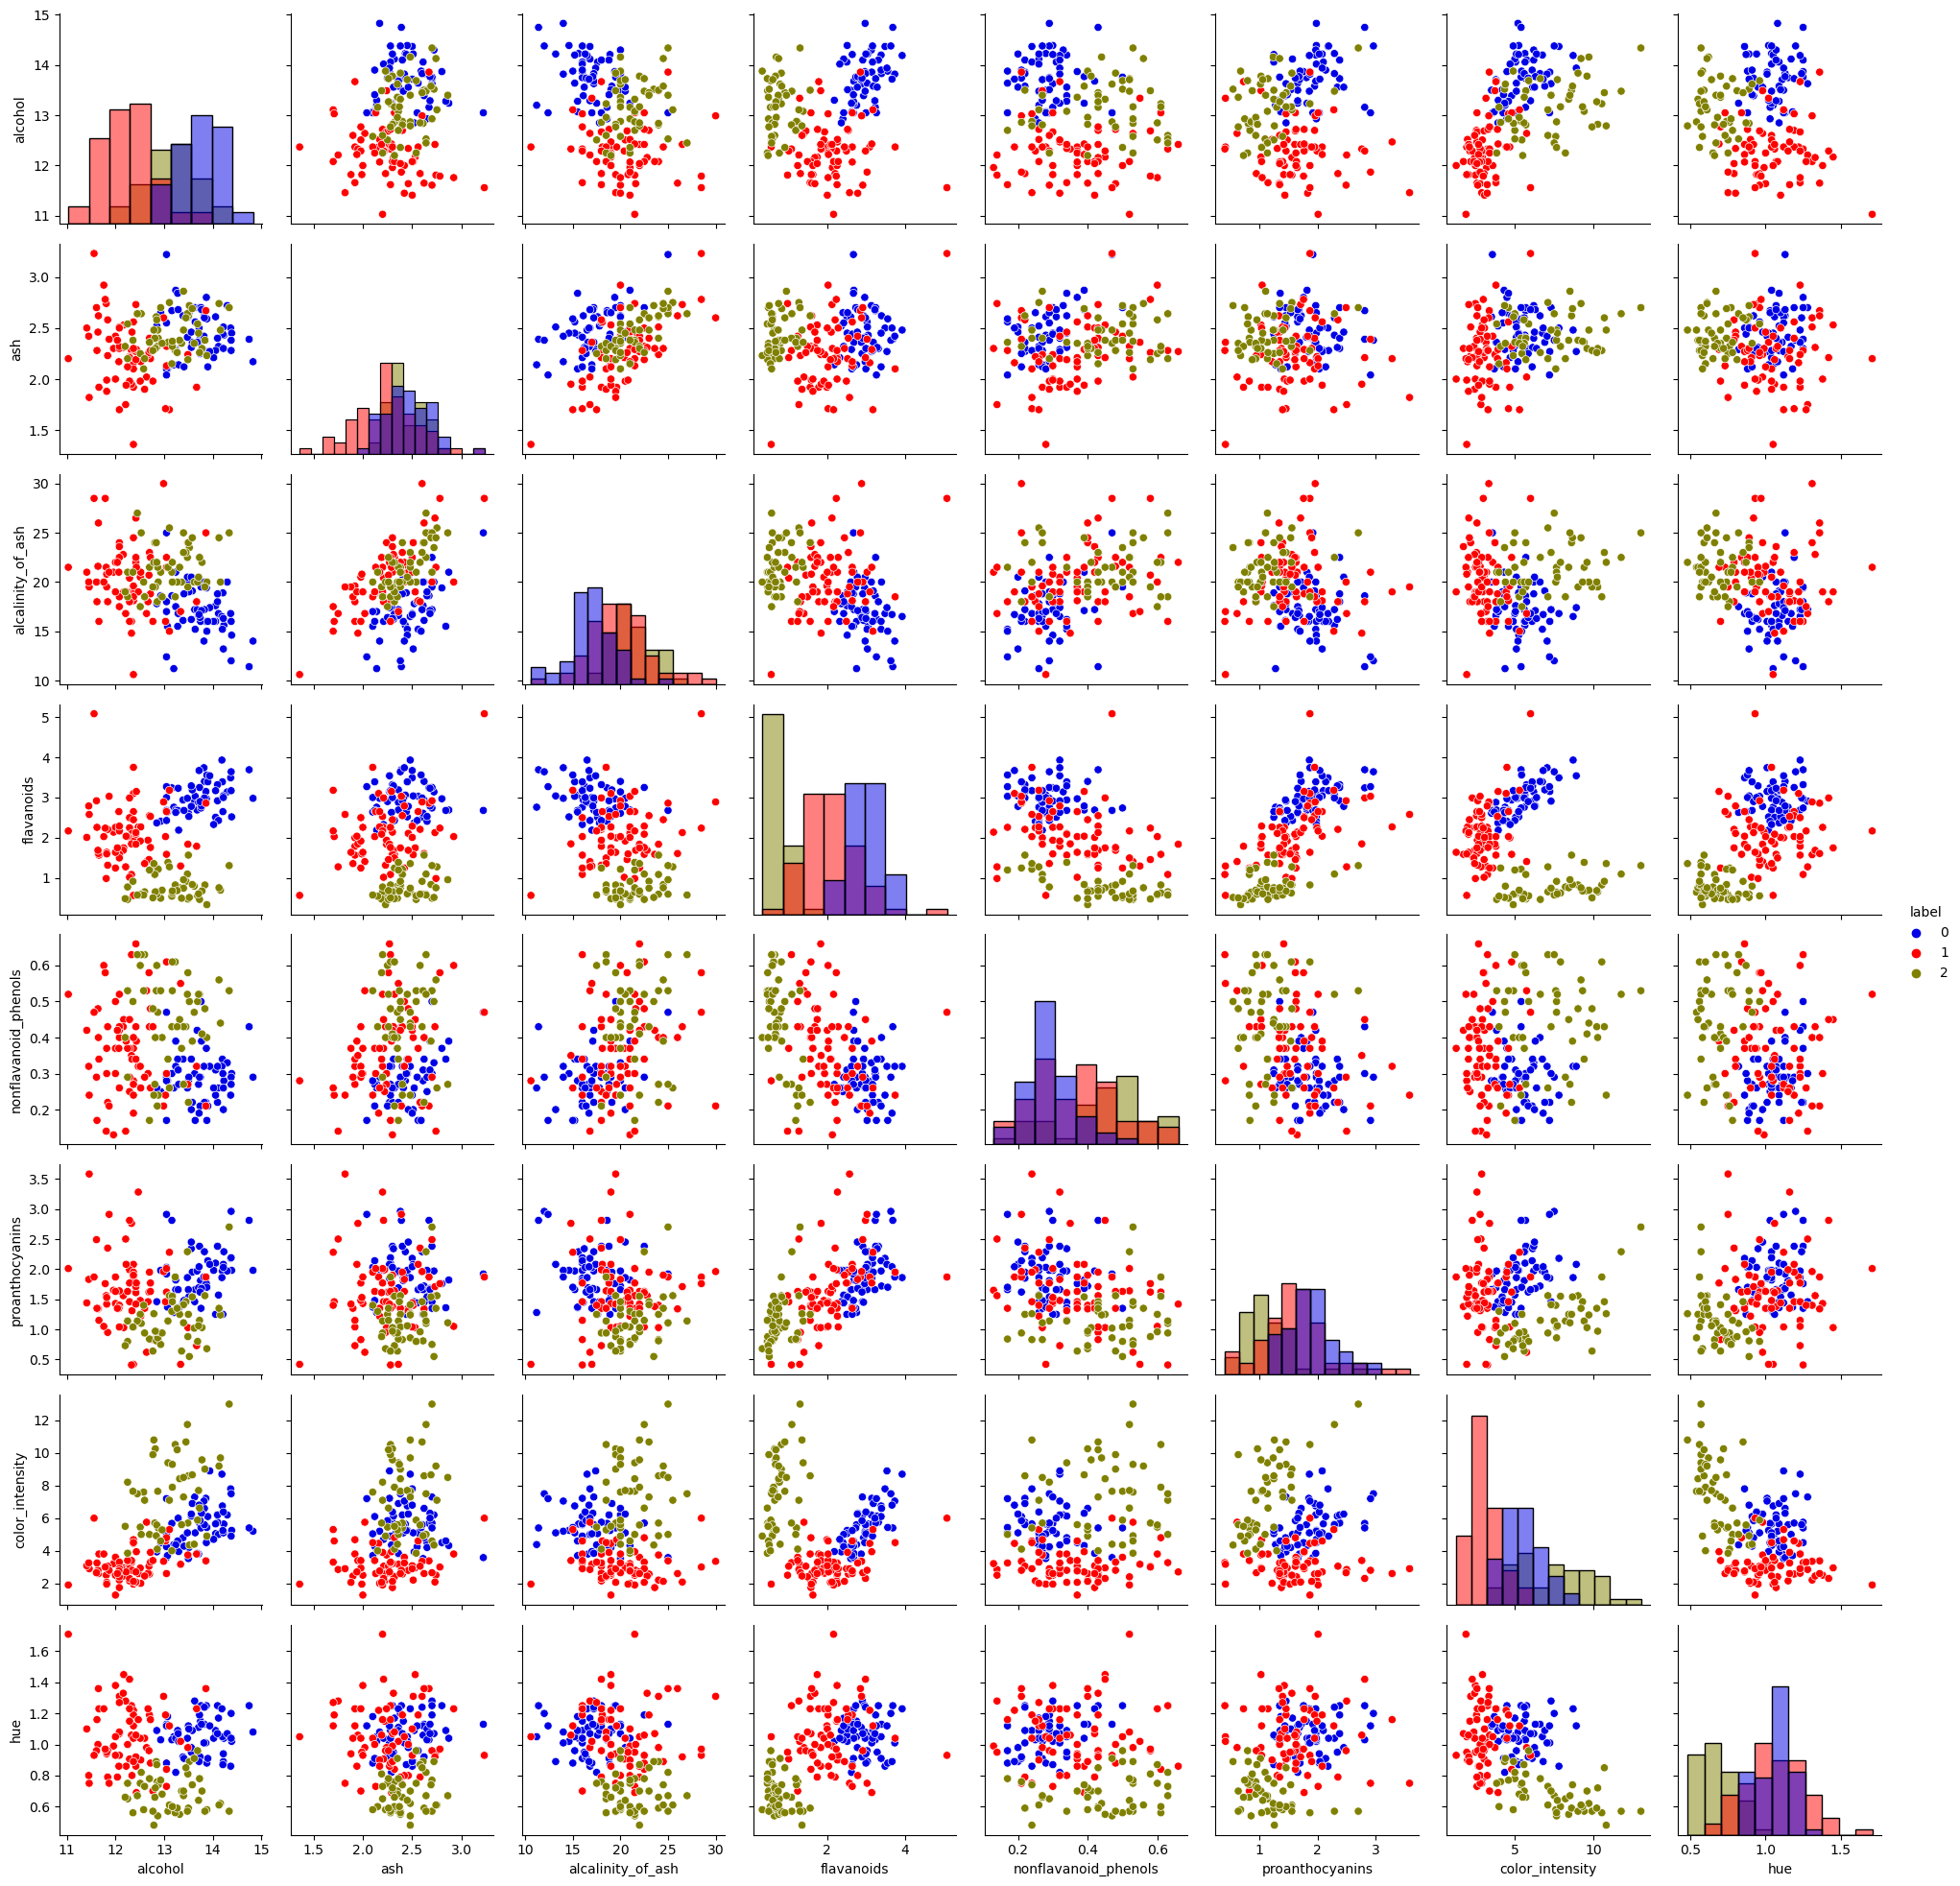

In [8]:
color_map = {-1: (1, 1, 1), 0: (0, 0, .9), 1: (1, 0, 0), 2: (.5, .5, 0)}
graph = sns.PairGrid(df1, hue="label", palette=color_map)
graph.map_diag(sns.histplot)
graph.map_offdiag(sns.scatterplot);
graph.add_legend();

Widać, że klasy w kolumnach 'nonflavanoid_phenols', 'proanthocyanins', 'ash', 'alcalinity_of_ash' są bardzo wymieszane, więc je możemy od razu odrzucić

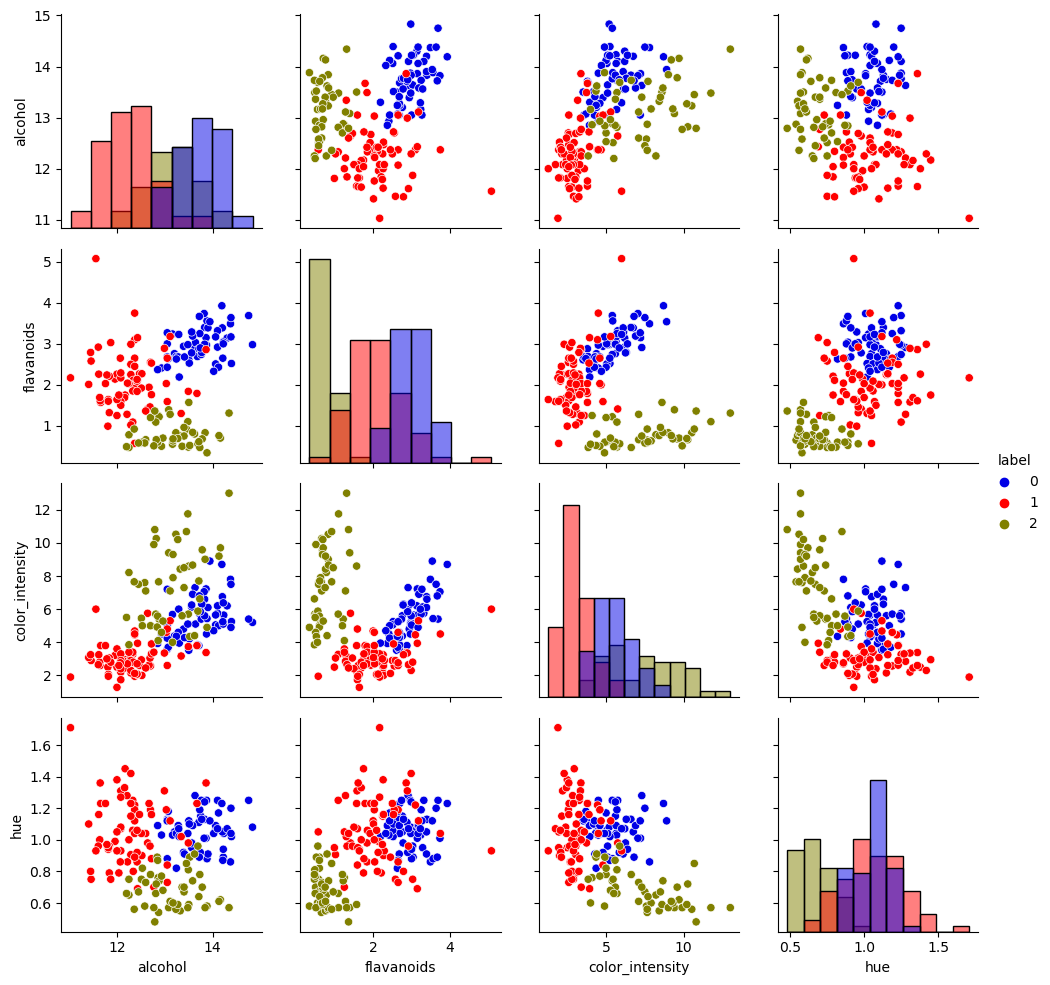

In [142]:
color_map = {-1: (1, 1, 1), 0: (0, 0, .9), 1: (1, 0, 0), 2: (.5, .5, 0)}
graph = sns.PairGrid(df1.drop(['ash', 'alcalinity_of_ash','nonflavanoid_phenols', 'proanthocyanins'],axis=1),hue="label", palette=color_map)
graph.map_diag(sns.histplot)
graph.map_offdiag(sns.scatterplot);
graph.add_legend();

WYgląda na to, że najbardziej rozdzielone klasy są w zależności od kolumny 'flavanoids'. Wygląda na to, że są one najbardziej rozdzielone pod względem parametrów 'flavanoids' i 'color_intensity' lub 'flavanoids' i 'alcohol'

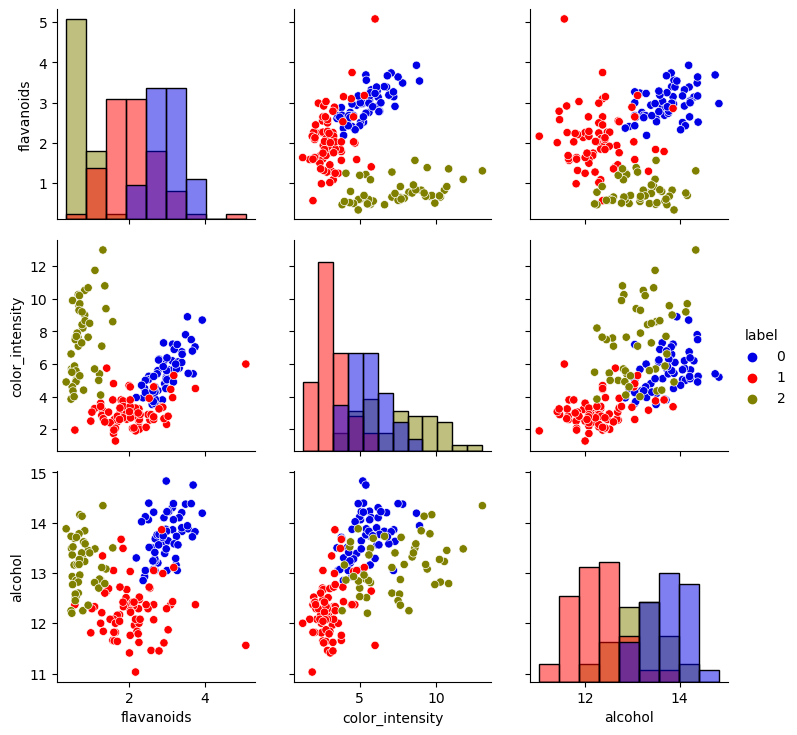

In [143]:
graph = sns.PairGrid(df1[['flavanoids','color_intensity','alcohol','label']], hue="label", palette=color_map)
graph.map_diag(sns.histplot)
graph.map_offdiag(sns.scatterplot);
graph.add_legend();

<AxesSubplot:xlabel='color_intensity', ylabel='Count'>

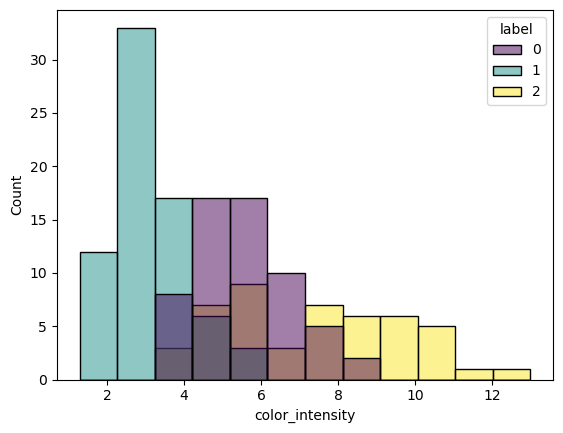

In [162]:
sns.histplot(data=df1,x='color_intensity',hue='label',palette='viridis')

<AxesSubplot:xlabel='alcohol', ylabel='Count'>

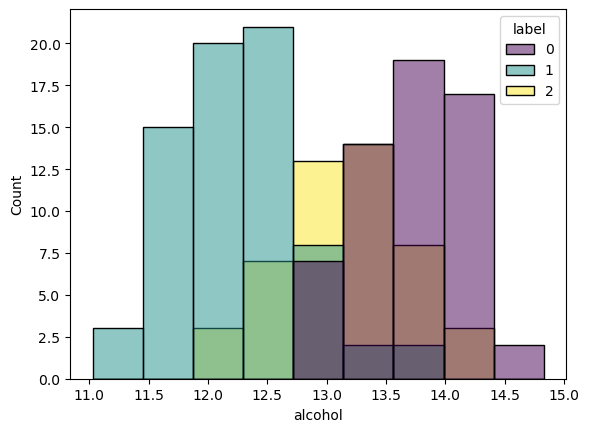

In [163]:
sns.histplot(data=df1,x='alcohol',hue='label',palette='viridis')

Koniec końców najbardziej rozdzielonymi wizualnie wydają się klasy w zależności od parametrów 'flavanoids' i 'color_intensity'. To, że parametr 'alcohol' nie jest taki dobry, najbardziej widać z histogramu: klasy 0 i 1 są rozdzielone, ale prawie w całości pokrywają klasę 2 

# Zadanie 2 (5 pkt)
### Klasyfikacja win
**Model:** GaussianNB

**Wejście:** Właściwości chemiczne win

**Wyjście:** Klasa wina

**Proszę:**

1. (0.5 pkt) Wybrać z danych dwie kolumny wytypowane w zadaniu 1 i podzielić dane na zbiór treningowy i testowy. Dla uzyskania powtarzalnych wyników ustaw parametr `random_state=33` w funkcji `train_test_split`.
2. (1.5 pkt) Przeprowadzić 5-foldową walidację krzyżową (funckja w sklearn cross_val_score) **na zbiorze treningowym** oraz wypisać średnią i rozrzut miary ACC.
3. (1.5 pkt) Nauczyć jeszcze raz nowy model na całym **na zbiorze treningowym** (z podpunktu pierwszego). Następnie przetestować model na **na zbiorze testowym**, obliczając ACC i macierz pomyłek (ConfusionMatrixDisplay).
4. (1.5 pkt) Co wynika z macierzy pomyłek?  Skomentuj otrzymany wynik w kontekście wizualizacji z zadania 1.

In [4]:
# Wybrać z danych dwie kolumny wytypowane w zadaniu 1 i podzielić dane na zbiór treningowy i testowy.
# Dla uzyskania powtarzalnych wyników ustaw parametr random_state=33 w funkcji train_test_split.

df2 = df1[['flavanoids','color_intensity','label']]

X_train, X_test, y_train, y_test = train_test_split(df2.drop('label',axis=1), df2['label'], 
                                                    test_size=0.4, random_state=33)

In [168]:
# Przeprowadzić 5-foldową walidację krzyżową (funckja w sklearn cross_val_score) na zbiorze treningowym oraz wypisać średnią i rozrzut miary ACC.

value = cross_val_score(GaussianNB(), X_train, y_train , cv=5, scoring='accuracy')
print('Accuracy'+' = {0:.2f} +/- {1:.2f}'.format(value.mean(),value.std()))


Accuracy = 0.92 +/- 0.05


Accuracy:  0.89


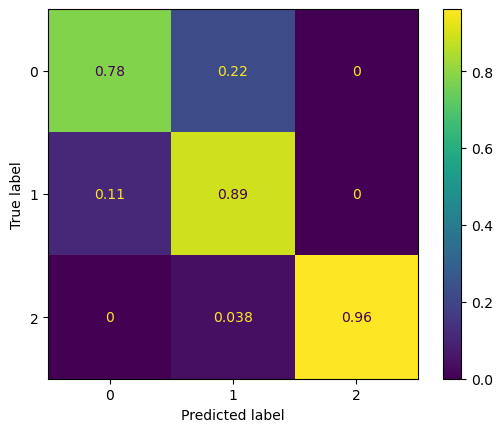

In [169]:
# Nauczyć jeszcze raz nowy model na całym na zbiorze treningowym (z podpunktu pierwszego). 
# Następnie przetestować model na na zbiorze testowym, obliczając ACC i macierz pomyłek (ConfusionMatrixDisplay).
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

ACC = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: ',round(ACC,2))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,normalize='true')


Miejsce na Twoje komentarze: jak widać z wykresów, klasa 3 jest najbardziej oddalona od reszty klas, więc jej klasyfikacja udaje się najlepiej. Klase 1 i 2 są bardziej ze sobą zmieszane, więc tutaj model bardziej się myli.

# Zadanie 3 (5 pkt)
### Klasyfikacja jakości hoteli

**Model:** MultinomialNB

**Wejście:** Opinie o hotelach (kolumna Review)

**Wyjście:** Klasa: dobry(1)/zły(0) hotel (powstanie z kolumny Rating)

**Proszę:** 
* (0.5 pkt) Stwórz kolumnę z klasą, gdzie 0 odpowiada hotelom które mają mniej niż 3 punkty w kolumne 'Rating', a 1 odpowiada hotelom które mają co najmniej 3 punkty w kolumne 'Rating'
* (0.5 pkt) Zrób transformatę (CountVectorizer) opinii, ustawiając parametr max_df=0.06.
* (1 pkt) Podziel dane na zbiór treningowy i testowy (sklearn train_test_split). Zastanów się nad doborem odpowiednich parametrów funkcji train_test_split, biorąc pod uwagę niezbalansowanie klas.
* (0.5 pkt) Naucz model na zbiorze treningowym.
* (2 pkt) Przetestuj model na zbiorze testowym, korzystając z wybranych przez Ciebie miar jakości (min 3). Wybór każdej miary uzasadnij oraz skomentuj jej wynik.
* (0.5 pkt) Wypisz po 10 słów dla obu klas, które były najistotniejsze dla modelu.

## Wczytanie danych:

Dane zawierają dwie kolumny, jedna z opinią o hotelu a druga z oceną (1-5). Twoim zadaniem będzie nauka modelu odróżniania dobrych hoteli od złych.

In [173]:
url = "https://www.fuw.edu.pl/~mpoziomska/data/tripadvisor_hotel_reviews.csv"
df3 = pd.read_csv(url)
df3.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [174]:
# Stwórz kolumnę z klasą, gdzie 0 odpowiada hotelom które mają mniej niż 3 punkty w kolumne 'Rating',
# a 1 odpowiada hotelom które mają co najmniej 3 punkty w kolumne 'Rating'
df3['klasa'] = (df3['Rating']>=3).astype(int)
df3.head()

,Review,Rating,klasa
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,1
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1


In [175]:
# Zrób transformatę (CountVectorizer) opinii, ustawiając parametr max_df=0.06.
text = df3['Review']
vectorizer = CountVectorizer(max_df=0.06)
vectorizer.fit(text)
text_transformed = vectorizer.transform(text)

In [110]:
df3.groupby('klasa').count()

,Review,Rating
klasa,,
0,3214,3214
1,17277,17277


In [181]:
# Podziel dane na zbiór treningowy i testowy (sklearn train_test_split).
# Zastanów się nad doborem odpowiednich parametrów funkcji train_test_split, biorąc pod uwagę niezbalansowanie klas.
y = df3['klasa']
X_train, X_test, y_train, y_test = train_test_split(text_transformed, y, test_size=0.4, stratify=y)

In [182]:
# Naucz model na zbiorze treningowym.
model3 = MultinomialNB();
model3.fit(X_train,y_train)

MultinomialNB()

In [183]:
# Przetestuj model na zbiorze testowym, korzystając z wybranych przez Ciebie miar jakości (min 3).
# Wybór każdej miary uzasadnij oraz skomentuj jej wynik.
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

y_pred = model3.predict(X_test)

print('Precision: ',round(precision_score(y_test, y_pred),2))
print('Recal;: ',round(recall_score(y_test, y_pred),2))
print('F1: ',round(f1_score(y_test, y_pred),2))
print('MCC: ',round(matthews_corrcoef(y_test, y_pred),2))

Precision:  0.93
Recal;:  0.97
F1:  0.95
MCC:  0.66


In [184]:
# Wypisz po 10 słów dla obu klas, które były najistotniejsze dla modelu.
feature_names = vectorizer.get_feature_names_out()
feature_names = np.array(feature_names)
coeff = np.exp(model3.feature_log_prob_)
imp_1 = np.argsort(-coeff[1])[:10]
imp_0 = np.argsort(-coeff[0])[:10]
print('Słowa, które mają największe prawdopodobieństwo wystąpienia w kategorii 1:')
print(feature_names[imp_1])
print('Słowa, które mają największe prawdopodobieństwo wystąpienia w kategorii 0:')
print(feature_names[imp_0])

Słowa, które mają największe prawdopodobieństwo wystąpienia w kategorii 1:
['kids' 'club' 'ocean' 'san' 'cana' 'punta' 'metro' 'parking' 'ate' 'park']
Słowa, które mają największe prawdopodobieństwo wystąpienia w kategorii 0:
['manager' 'dirty' 'worst' '00' 'rude' 'finally' 'tried' 'later' 'poor'
 'terrible']
